In [1]:
!pip install tensorflow-gpu

    100% |████████████████████████████████| 345.2MB 53kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/_bakalarka/dataset_interpolation/* .
!cp gdrive/My\ Drive/_bakalarka/_my_tools.py .
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


total 949896
drwx------ 3 root root      4096 Mar 14 06:50 gdrive
-rw------- 1 root root      1643 Mar 14 06:50 _my_tools.py
drwxr-xr-x 1 root root      4096 Mar  8 17:26 sample_data
-rw------- 1 root root 129687680 Mar 14 06:50 X_test.npy
-rw------- 1 root root 518750336 Mar 14 06:50 X_train.npy
-rw------- 1 root root  64843904 Mar 14 06:50 y_test.npy
-rw------- 1 root root 259375232 Mar 14 06:50 y_train.npy


In [0]:
import tensorflow as tf
from tensorflow import keras
import _my_tools as mt
import numpy as np

def compareRes(i,folder=None):
    mt.showImgGC(str(i).zfill(2),X_test[i,:,:,0],y_test[i,:,:,0],res[i,:,:,0],X_test[i,:,:,1],folder=folder)

In [0]:
X_train, y_train, X_test, y_test = mt.loadDataFloat("")

X_train = X_train.swapaxes(1,3)
X_train = X_train.swapaxes(1,2)
X_test = X_test.swapaxes(1,3)
X_test = X_test.swapaxes(1,2)

y_train = np.expand_dims(y_train,3)
y_test = np.expand_dims(y_test,3)

In [0]:
X_train.shape

(63324, 64, 64, 2)

In [0]:
def convBlock(x, depth):
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(x)
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(l)
  l = keras.layers.MaxPooling2D((2,2),padding='same')(l)
  
  return l

def deconvBlock(x, depth):
  l = keras.layers.Conv2DTranspose(depth,(4,4),strides=2,padding='same',activation='relu')(x)
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(l)
  
  return l
  


input_img = keras.layers.Input((64,64,2))

c1 = convBlock(input_img, 8)
c2 = convBlock(c1, 32)
c3 = convBlock(c2, 128)
encoded = convBlock(c3, 256)

d3 = deconvBlock(encoded, 128)
d3 = keras.layers.Add()([c3,d3])
d3 = keras.layers.ReLU()(d3)
d2 = deconvBlock(d3, 32)
d2 = keras.layers.Add()([c2,d2])
d2 = keras.layers.ReLU()(d2)
d1 = deconvBlock(d2, 8)
d1 = keras.layers.Add()([c1,d1])
d1 = keras.layers.ReLU()(d1)
decoded = deconvBlock(d1, 1)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_absolute_error')

In [0]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=False)

In [25]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 64, 64, 8)    152         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 64, 64, 8)    584         conv2d_21[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 

In [22]:
checkpoint_path = "08/cp"
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             save_weights_only=True,
                                             verbose=1)

batch_size = 1024
num_epoch = 4
#model training
model_log = autoencoder.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,          
          validation_data=(X_test, y_test),
          callbacks = [cp_callback])

Train on 63324 samples, validate on 15831 samples
Epoch 1/4
62464/63324 [============================>.] - ETA: 0s - loss: 32.0521
Epoch 00001: saving model to 08/cp

Consider using a TensorFlow optimizer from `tf.train`.
63324/63324 [==============================] - 43s 683us/sample - loss: 31.9922 - val_loss: 30.0659
Epoch 2/4
62464/63324 [============================>.] - ETA: 0s - loss: 31.2316
Epoch 00002: saving model to 08/cp

Consider using a TensorFlow optimizer from `tf.train`.
63324/63324 [==============================] - 43s 675us/sample - loss: 31.1662 - val_loss: 29.7191
Epoch 3/4
62464/63324 [============================>.] - ETA: 0s - loss: 30.7265
Epoch 00003: saving model to 08/cp

Consider using a TensorFlow optimizer from `tf.train`.
63324/63324 [==============================] - 43s 680us/sample - loss: 30.6461 - val_loss: 29.2702
Epoch 4/4
62464/63324 [============================>.] - ETA: 0s - loss: 30.2429
Epoch 00004: saving model to 08/cp

Consider using a 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


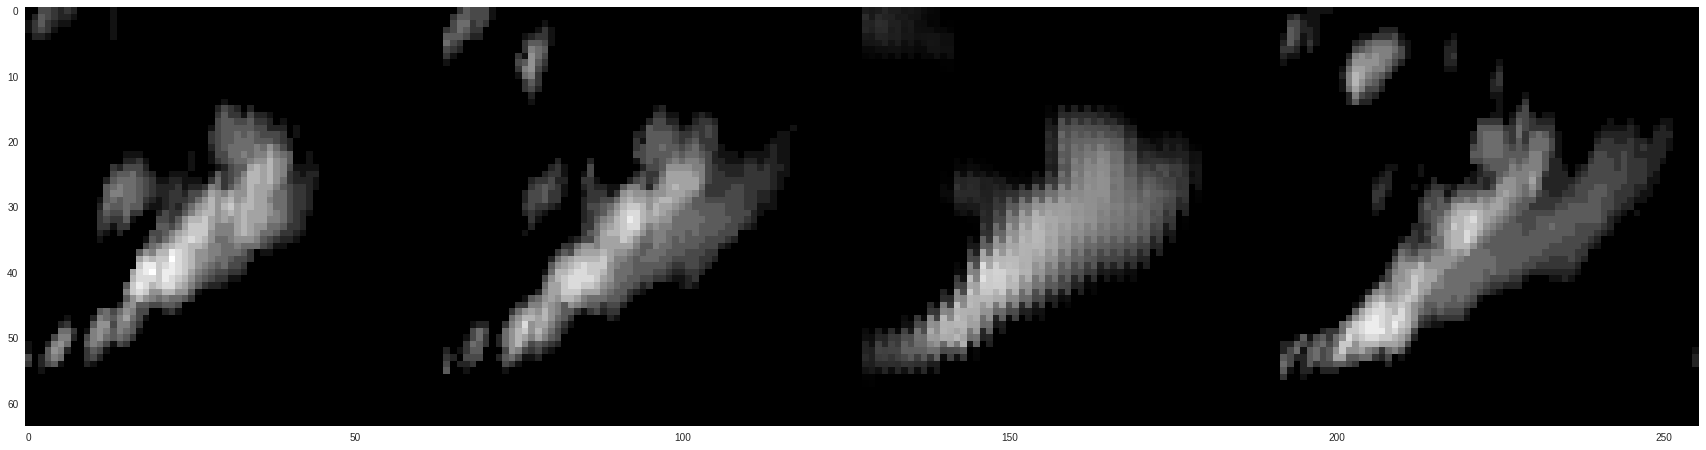

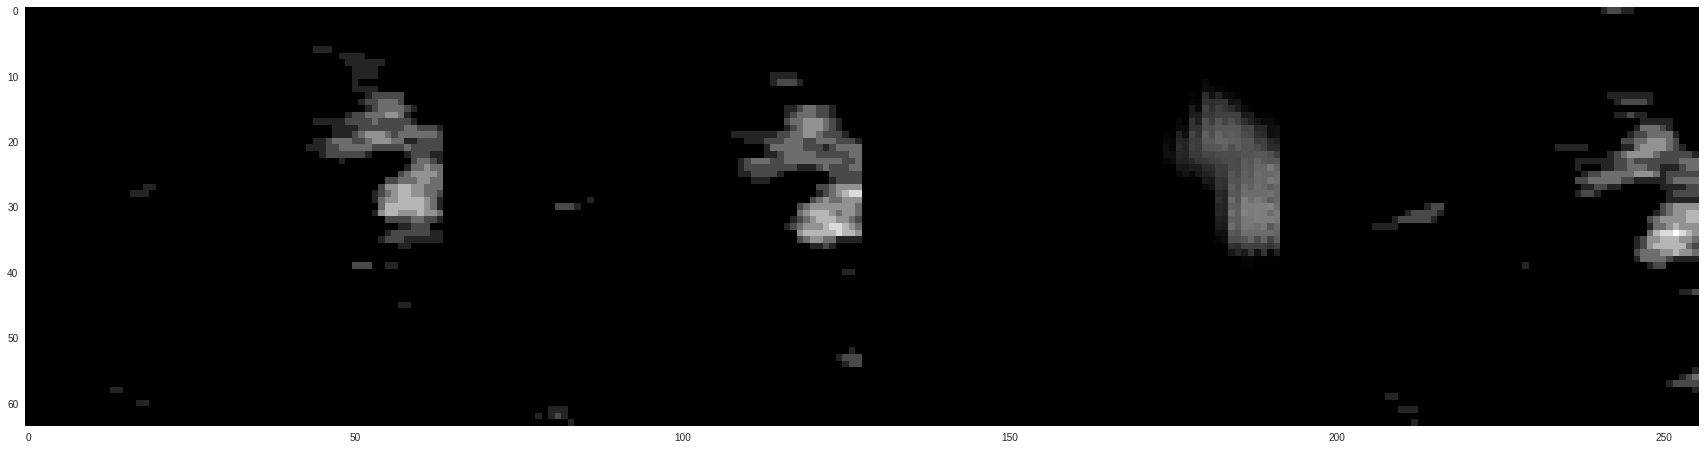

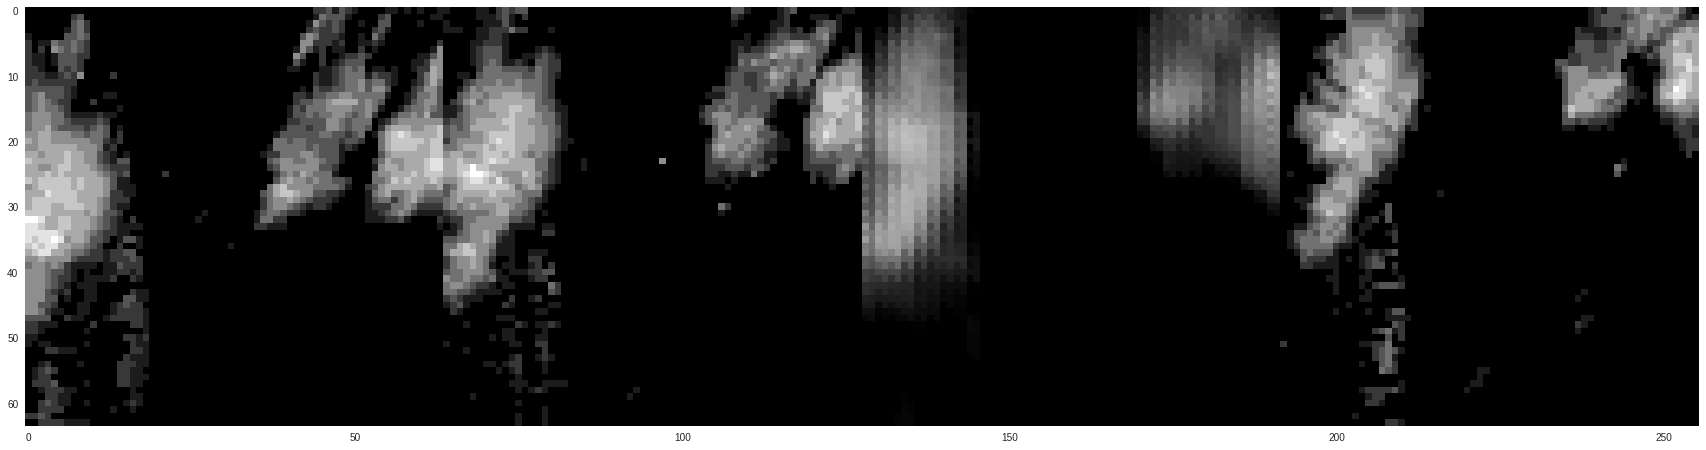

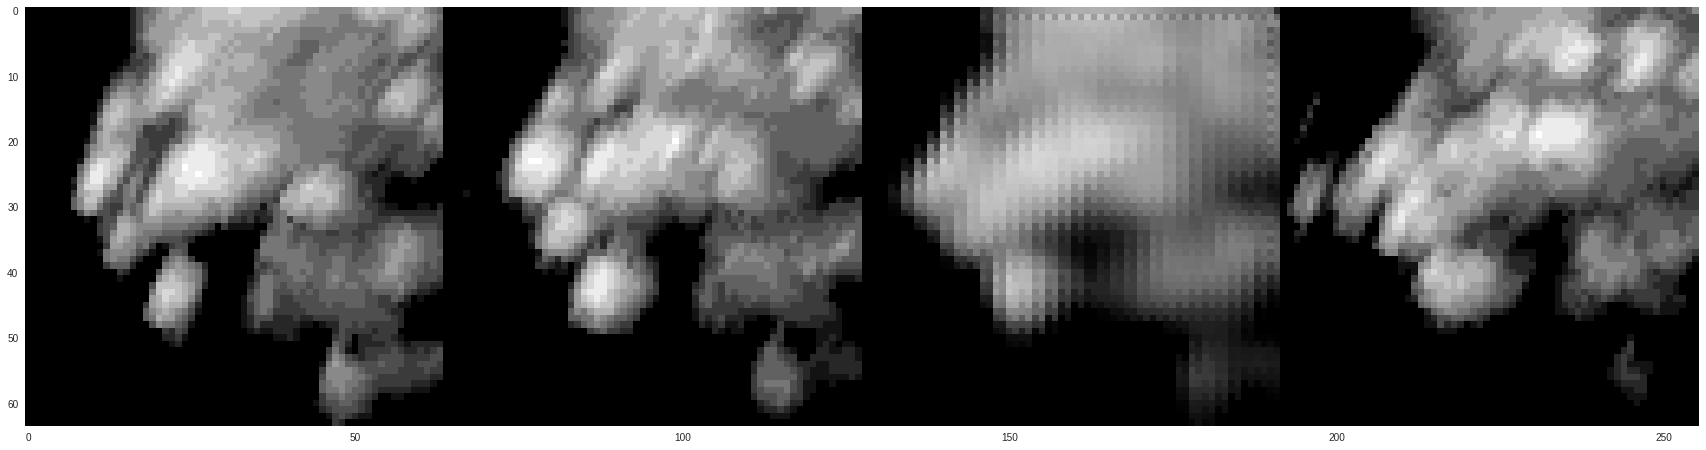

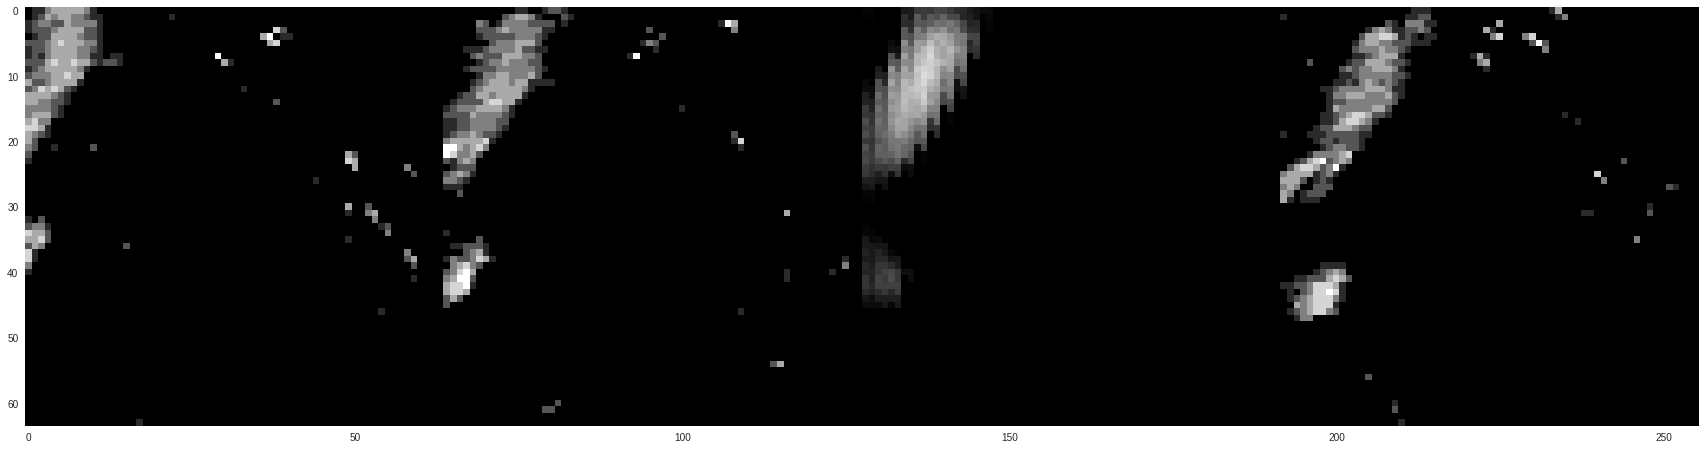

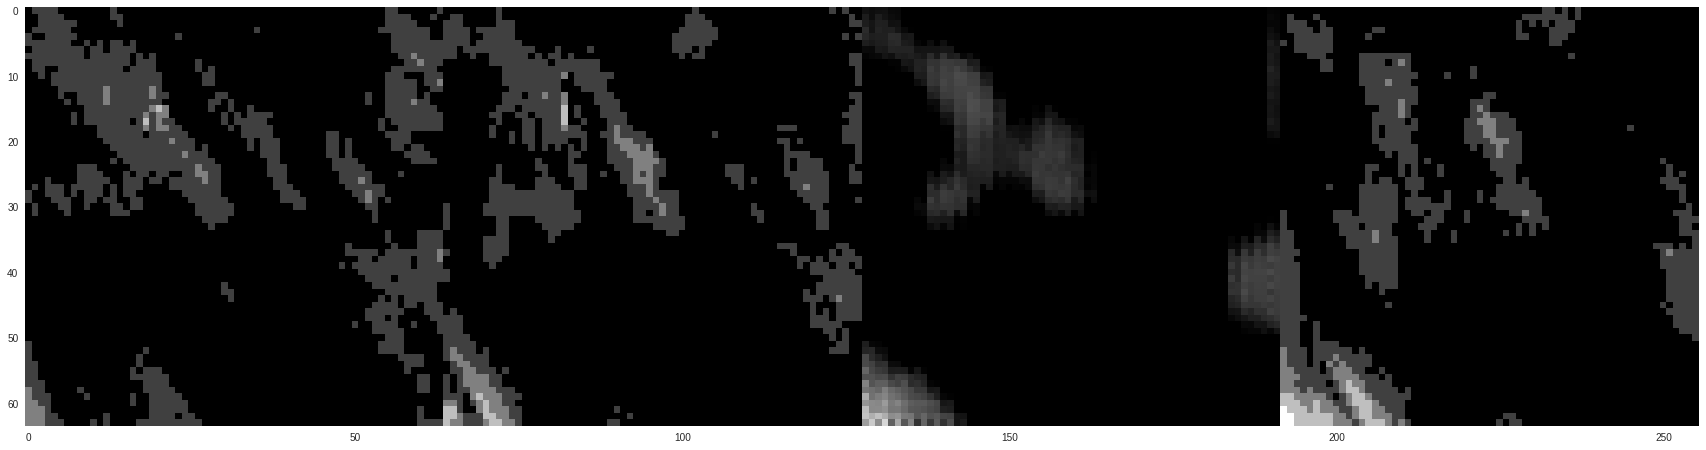

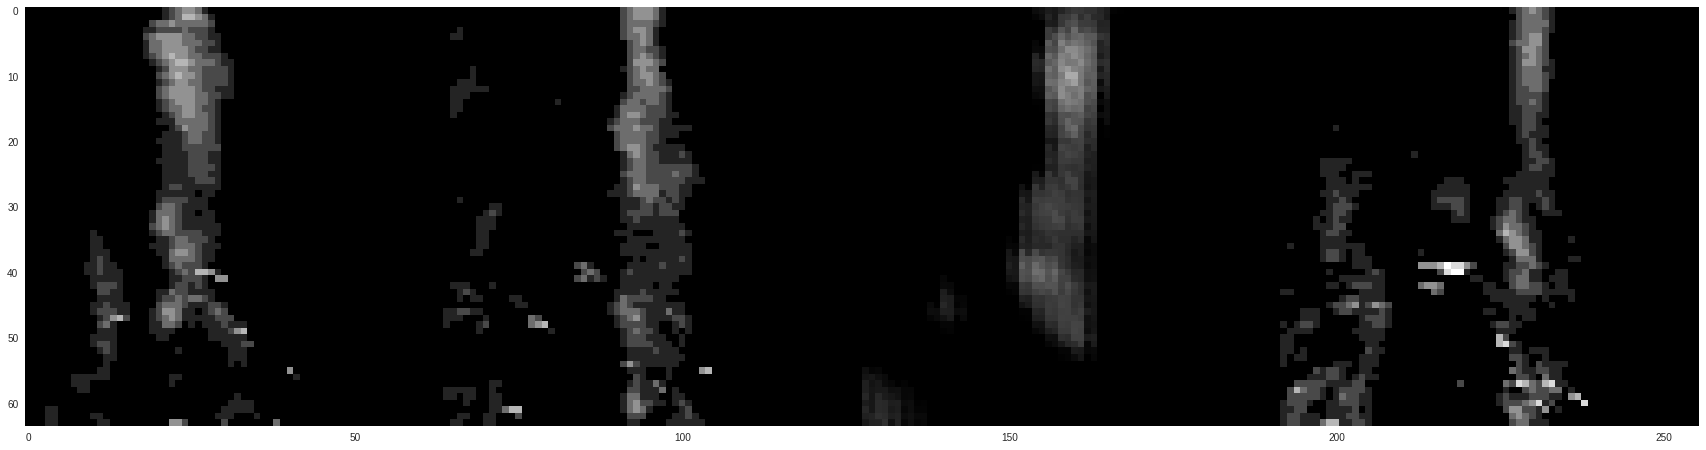

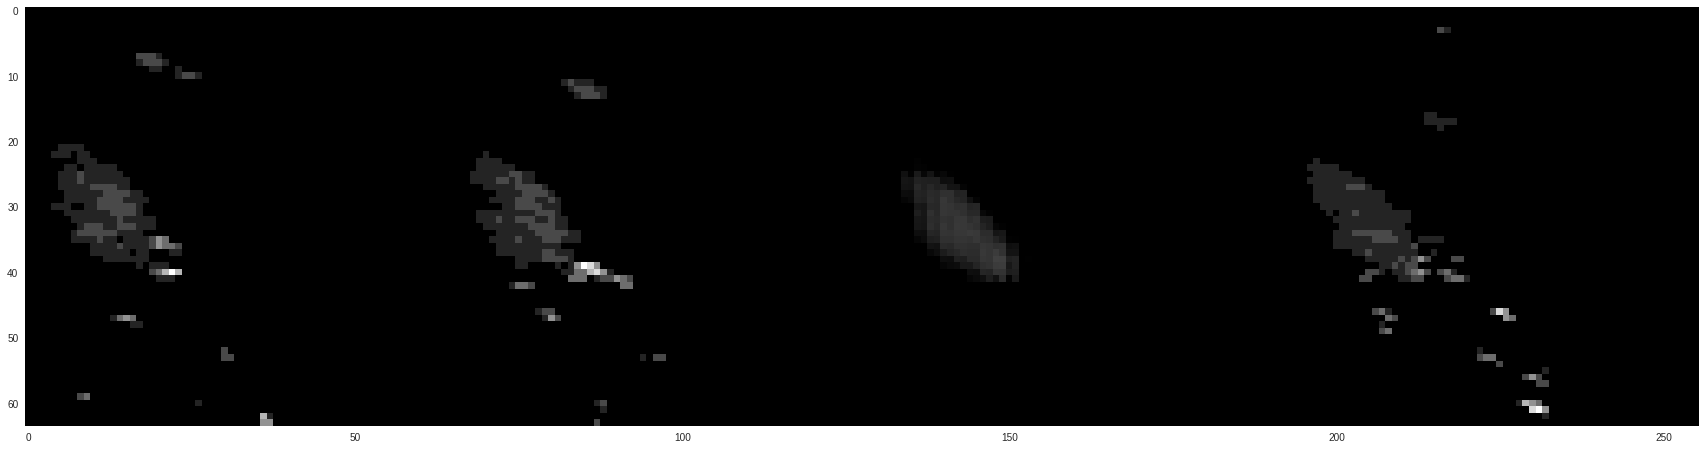

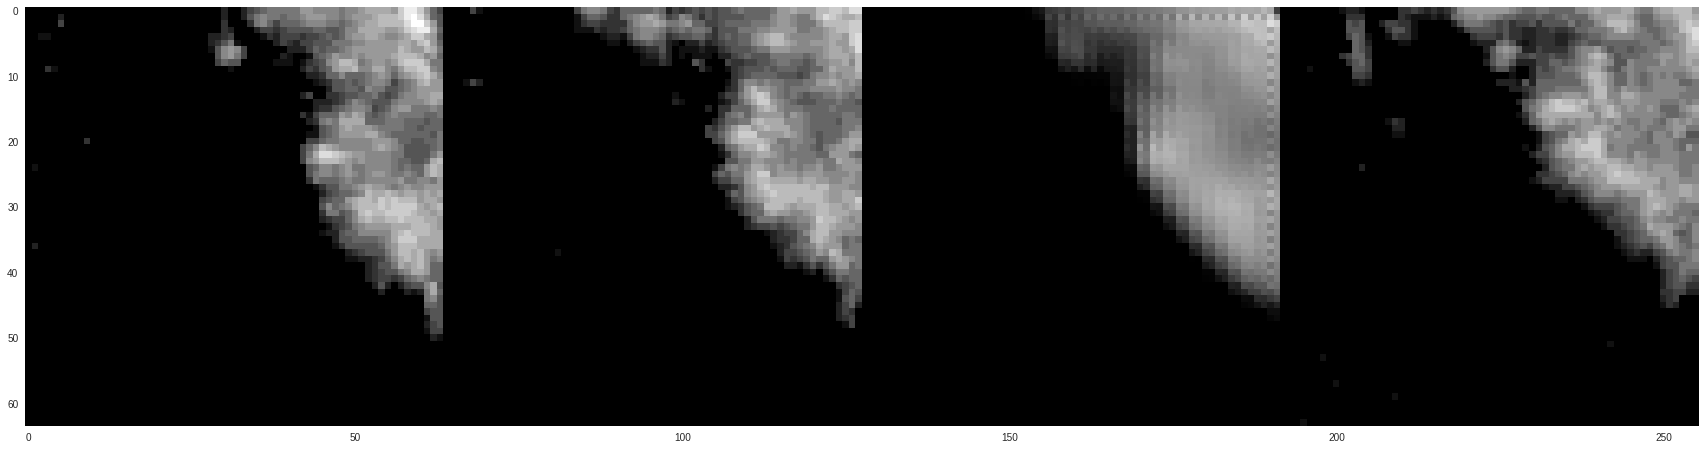

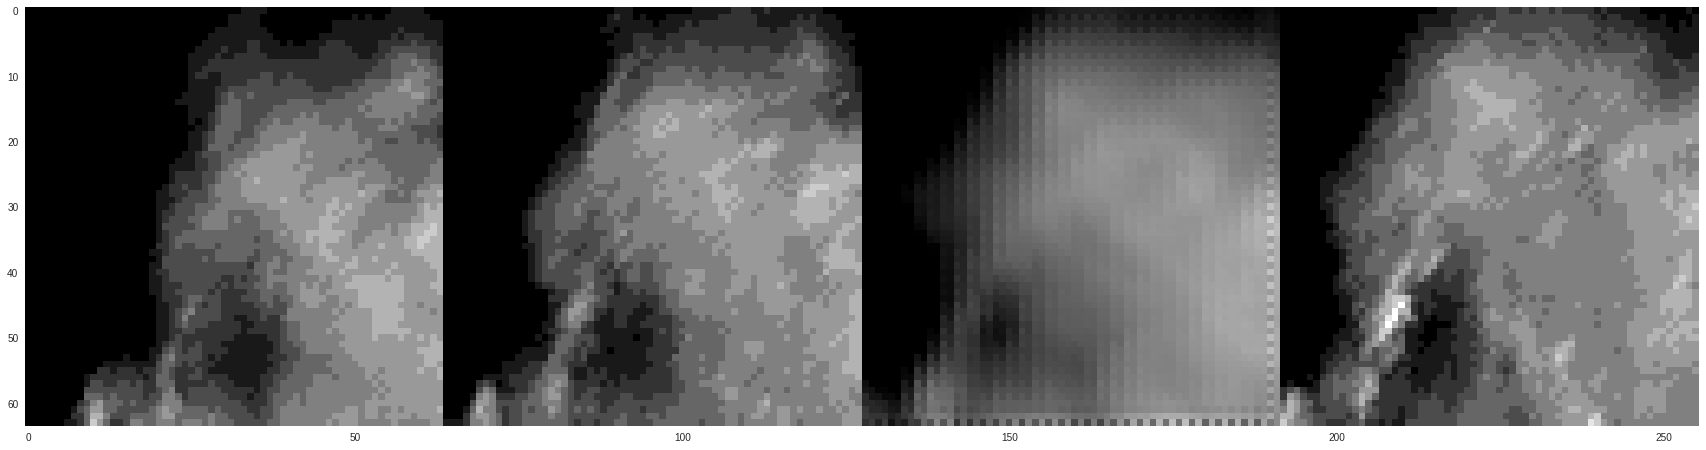

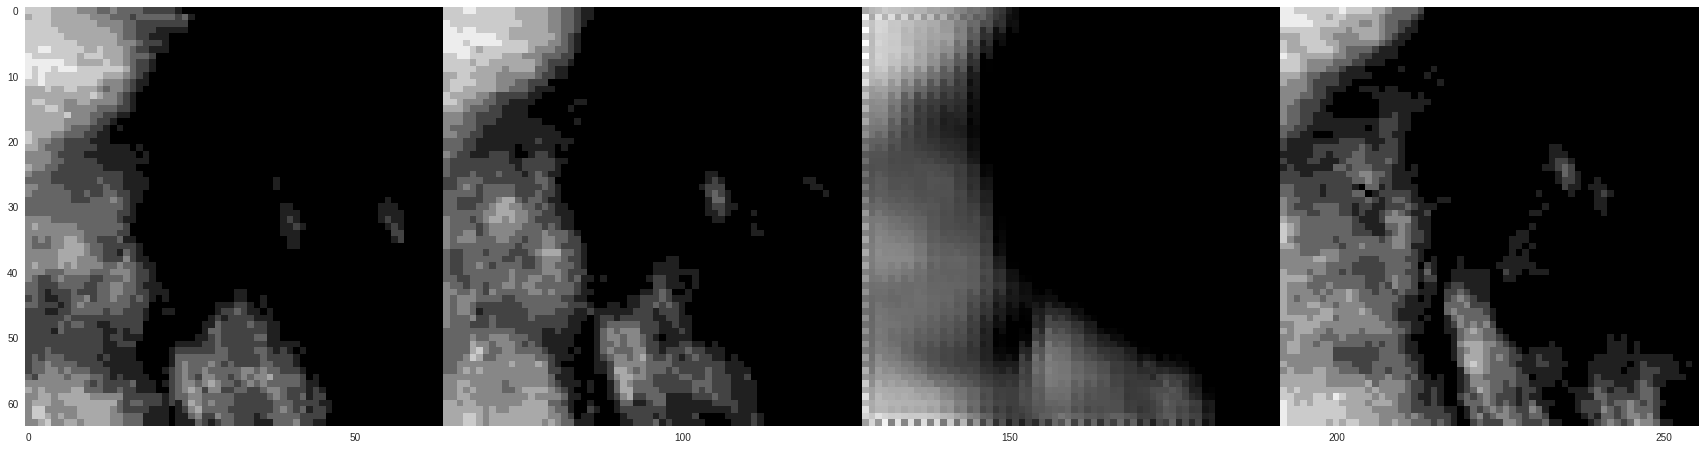

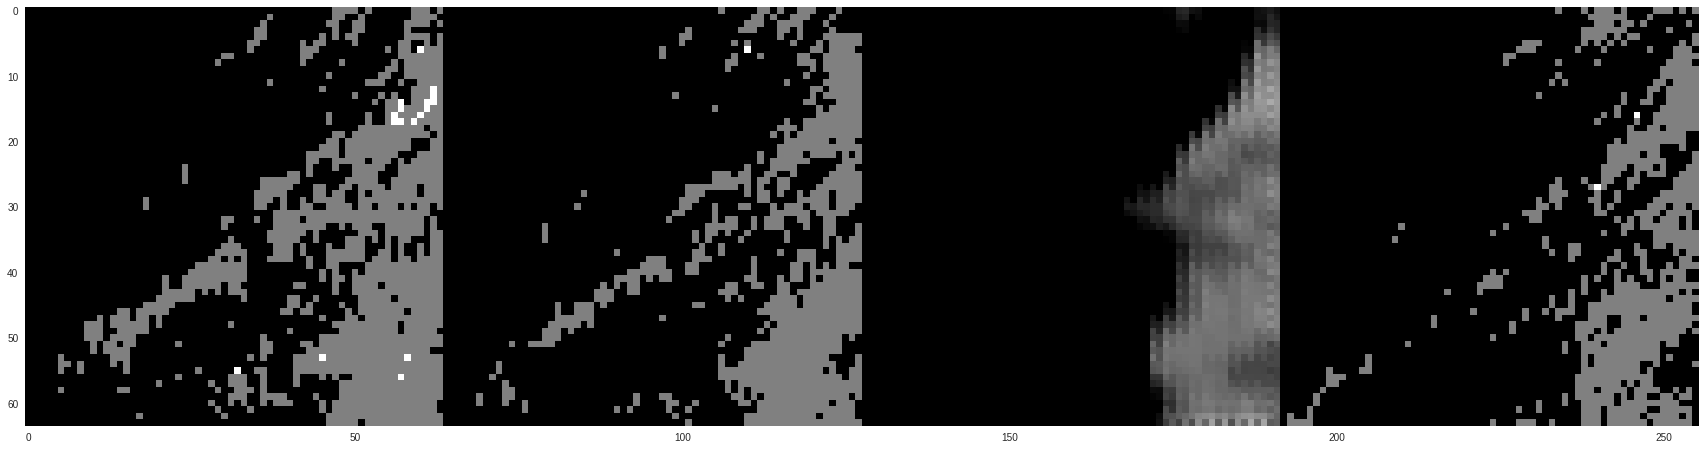

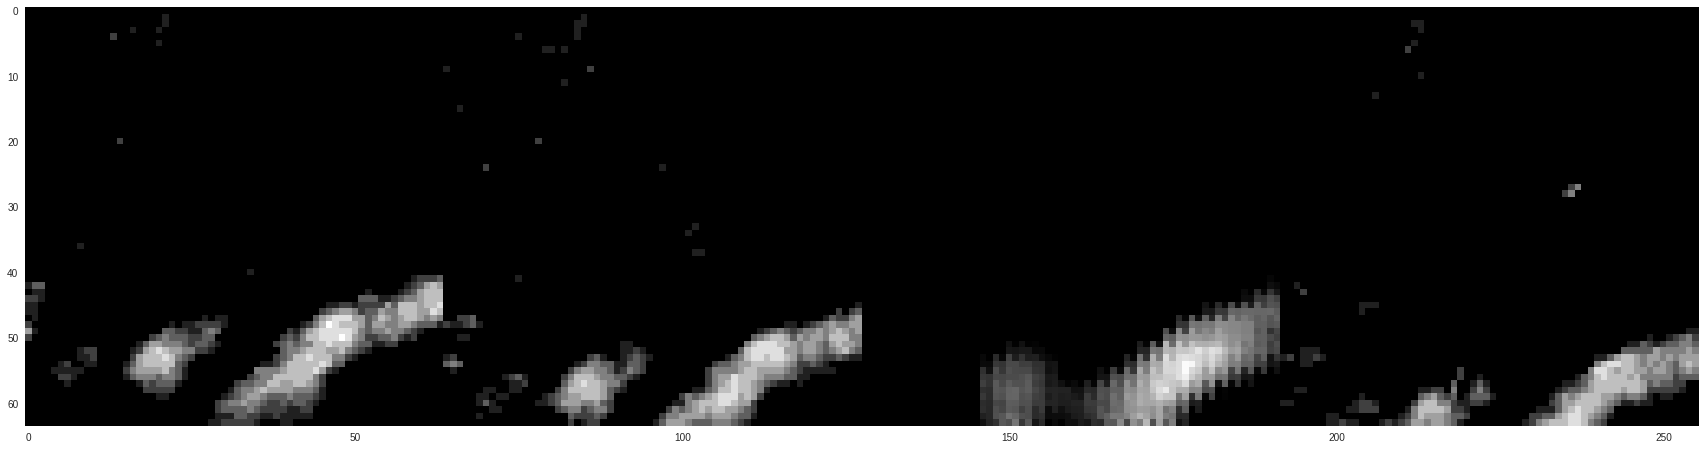

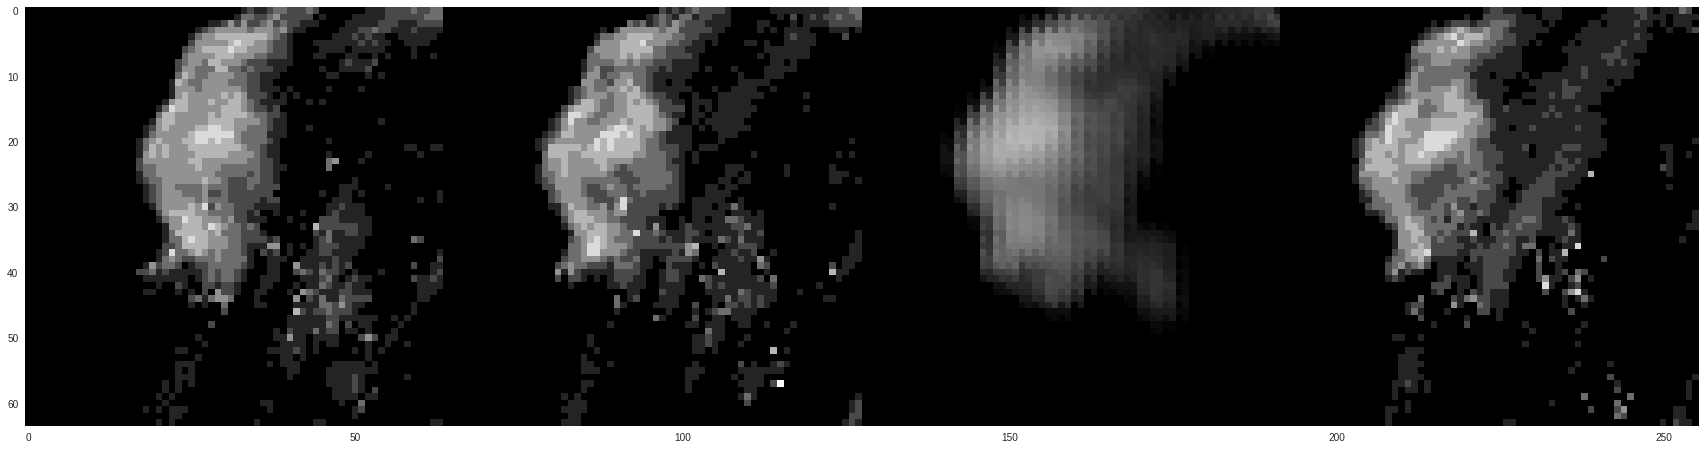

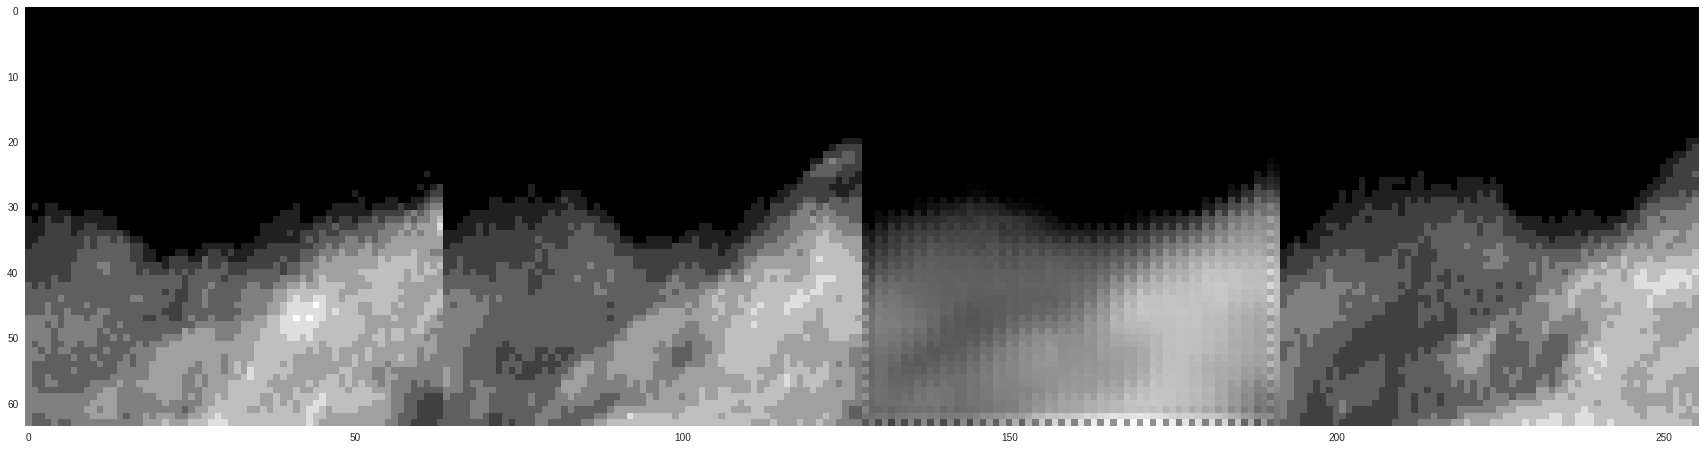

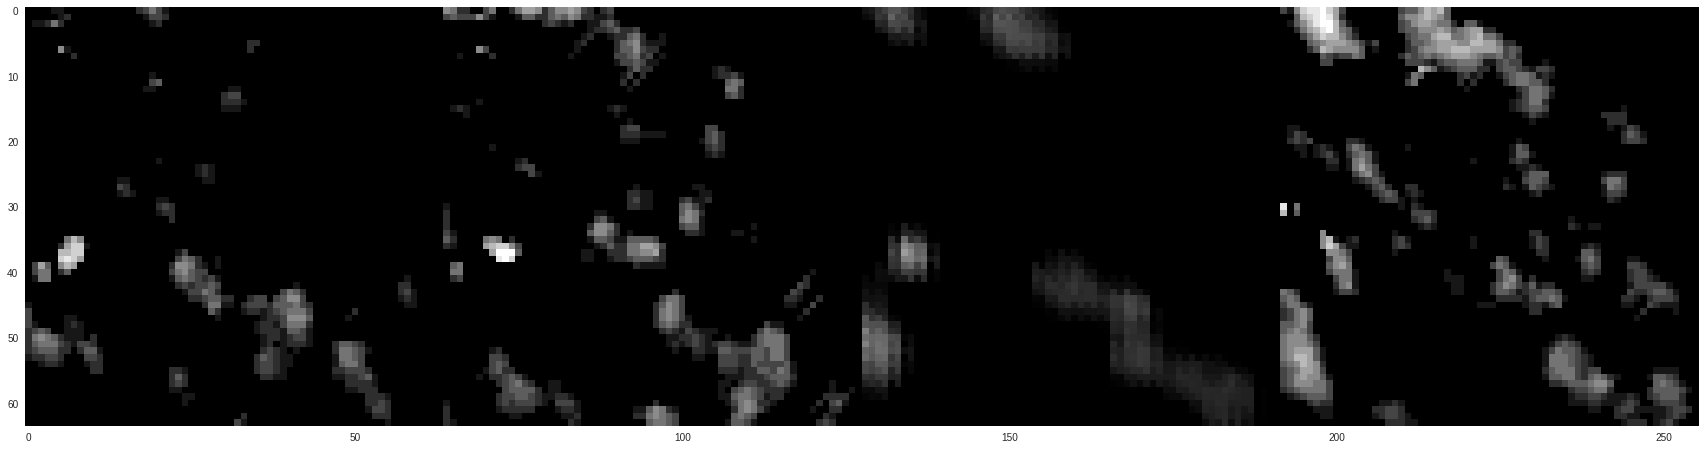

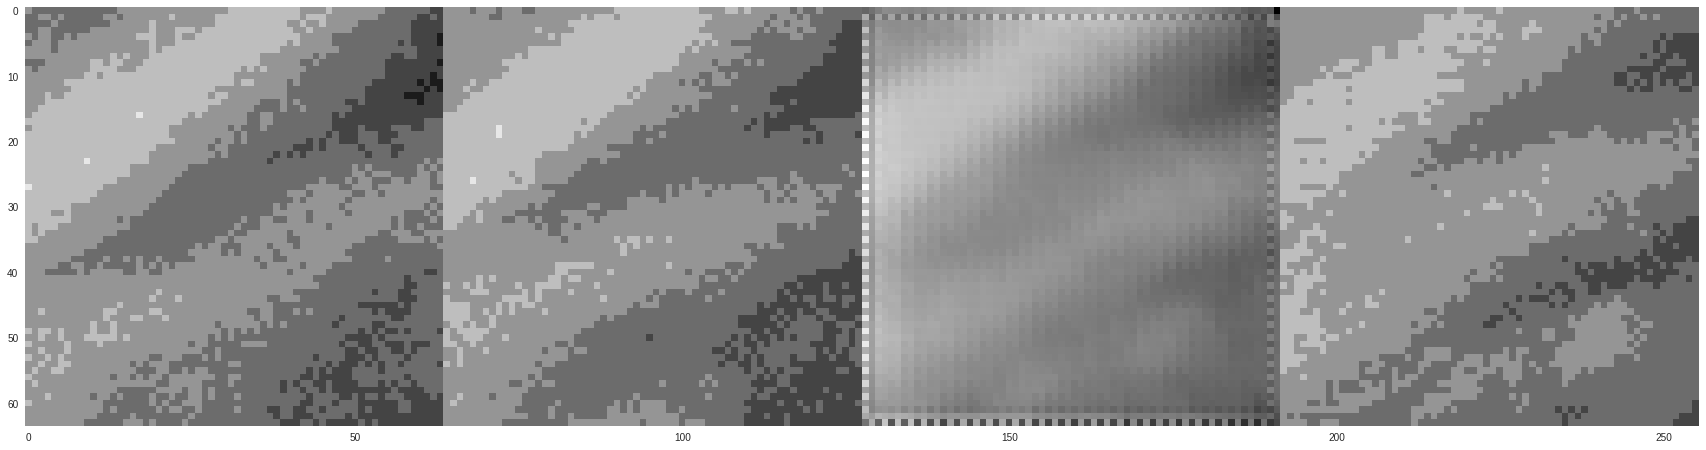

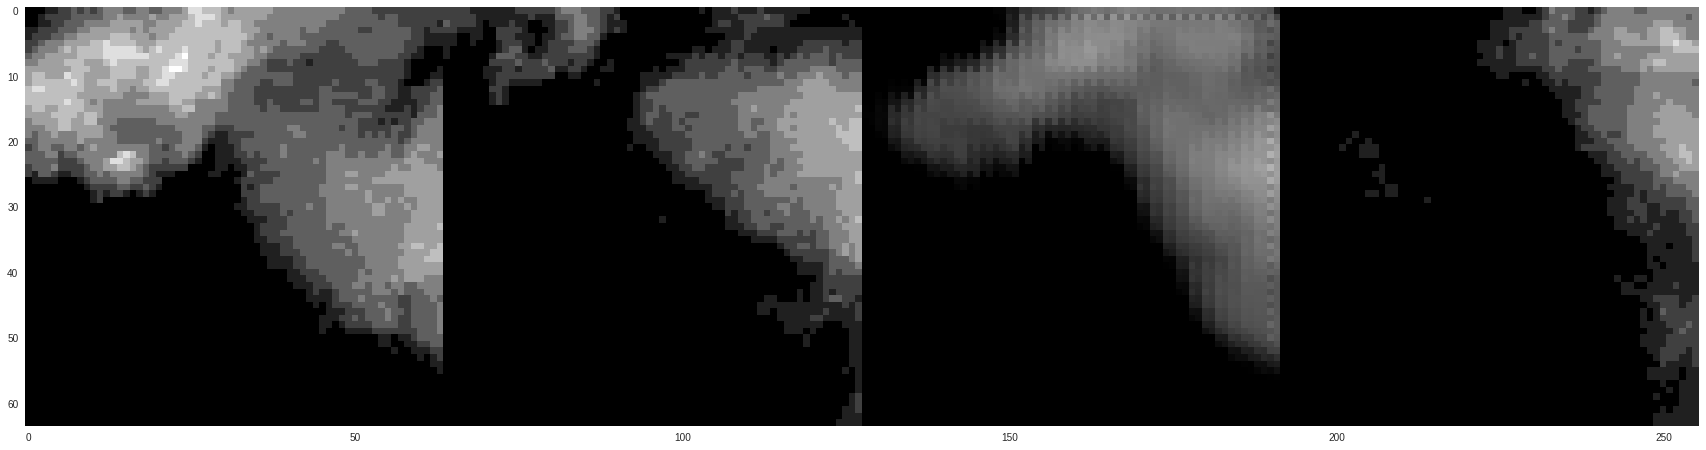

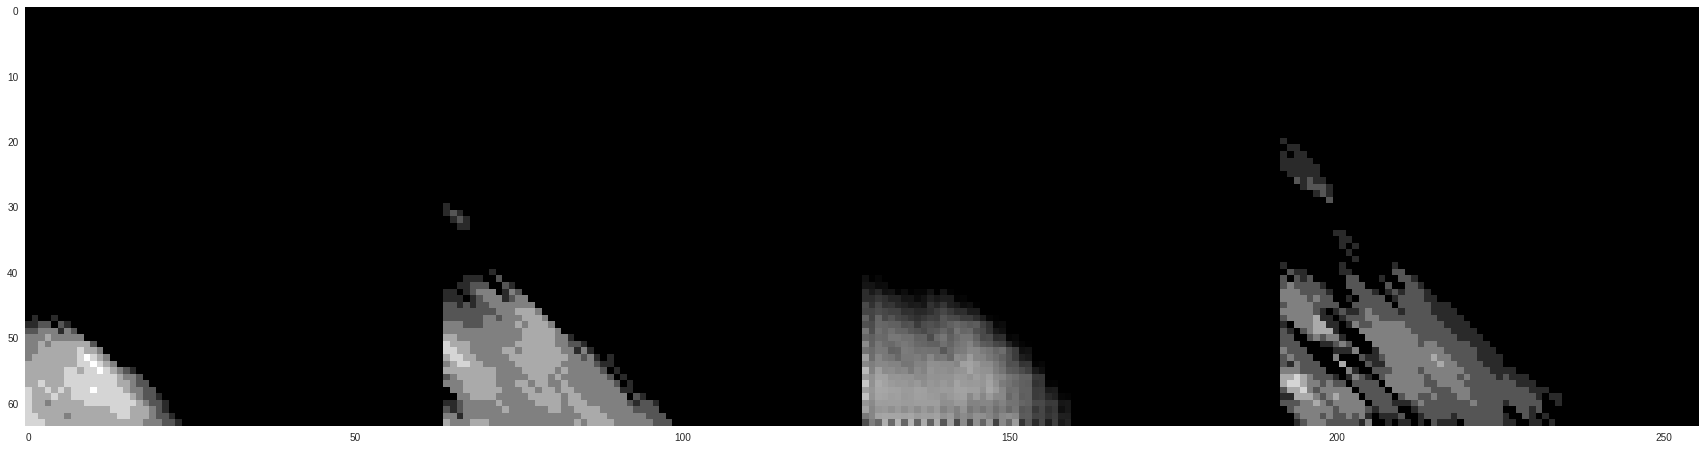

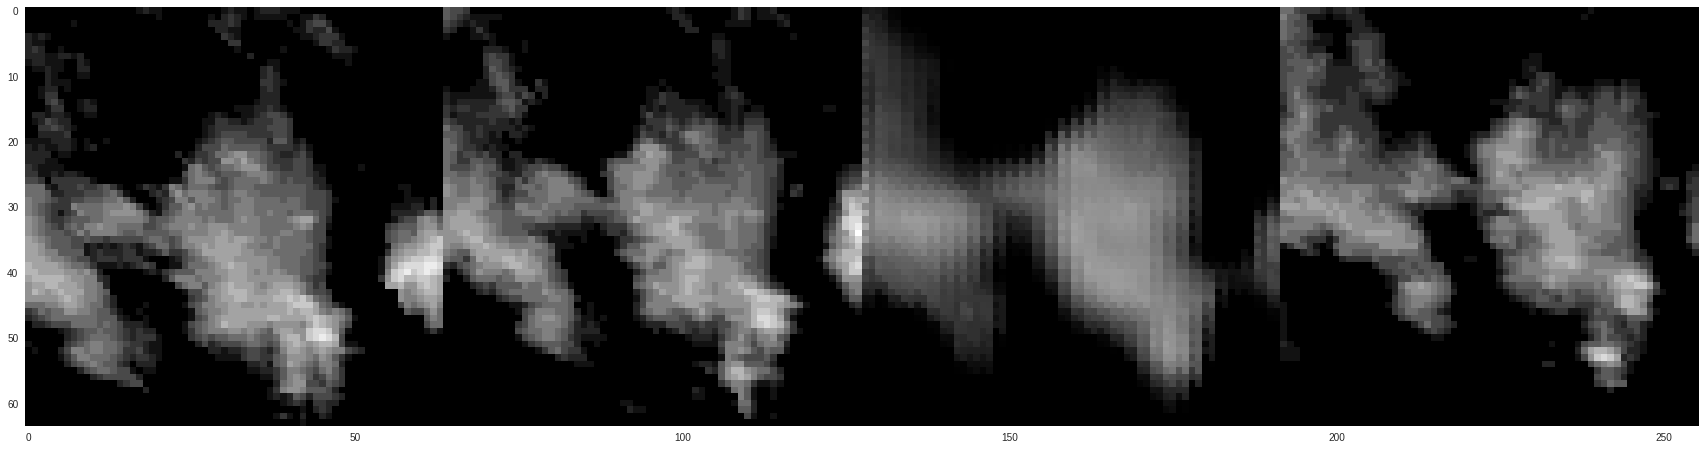

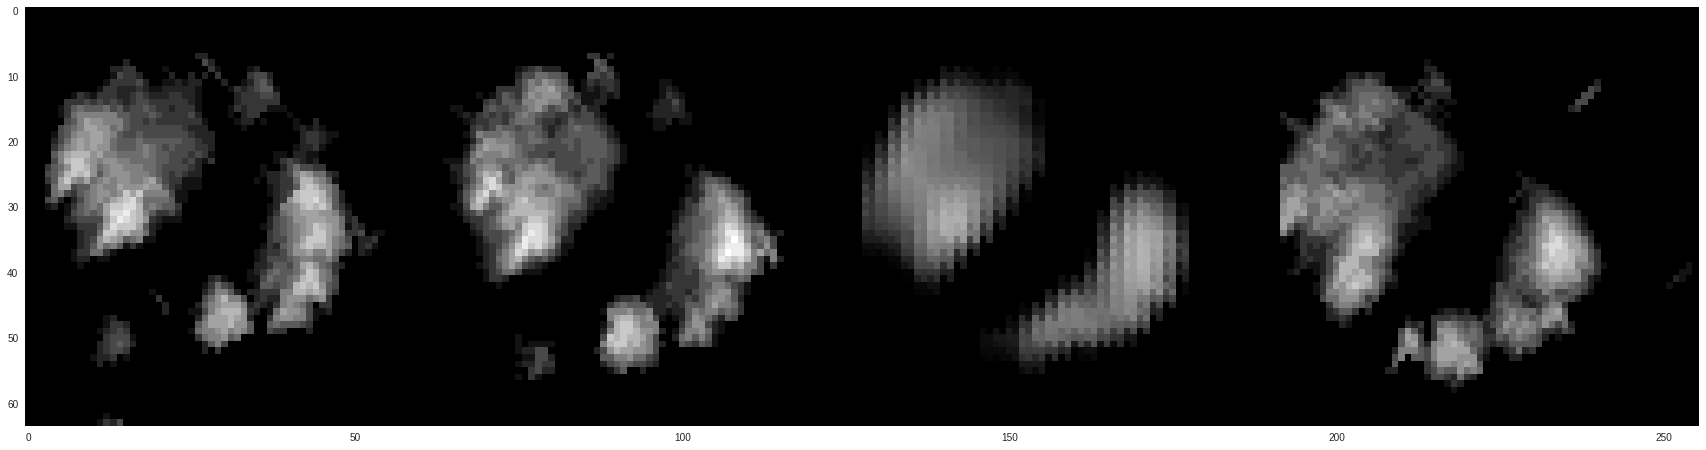

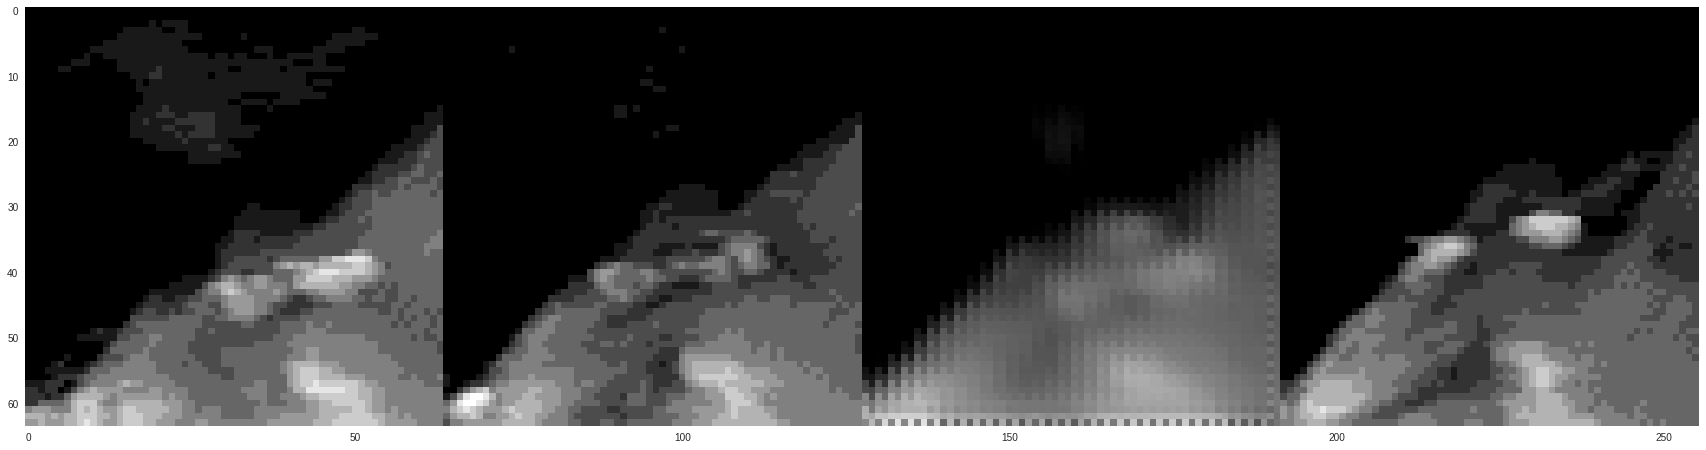

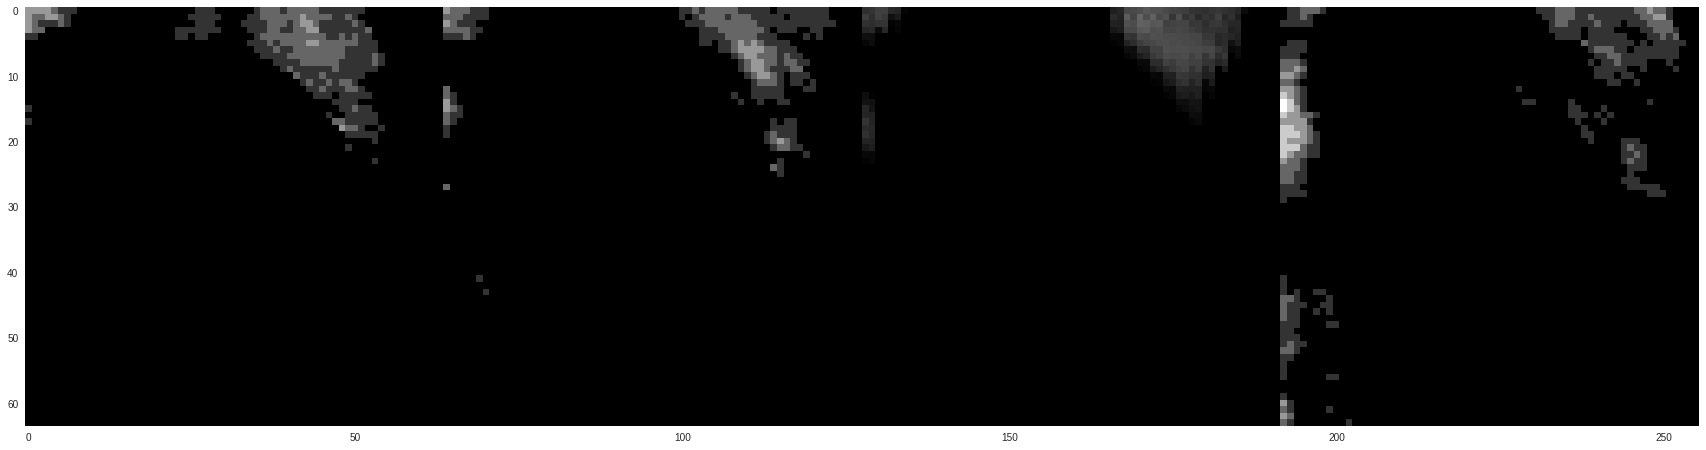

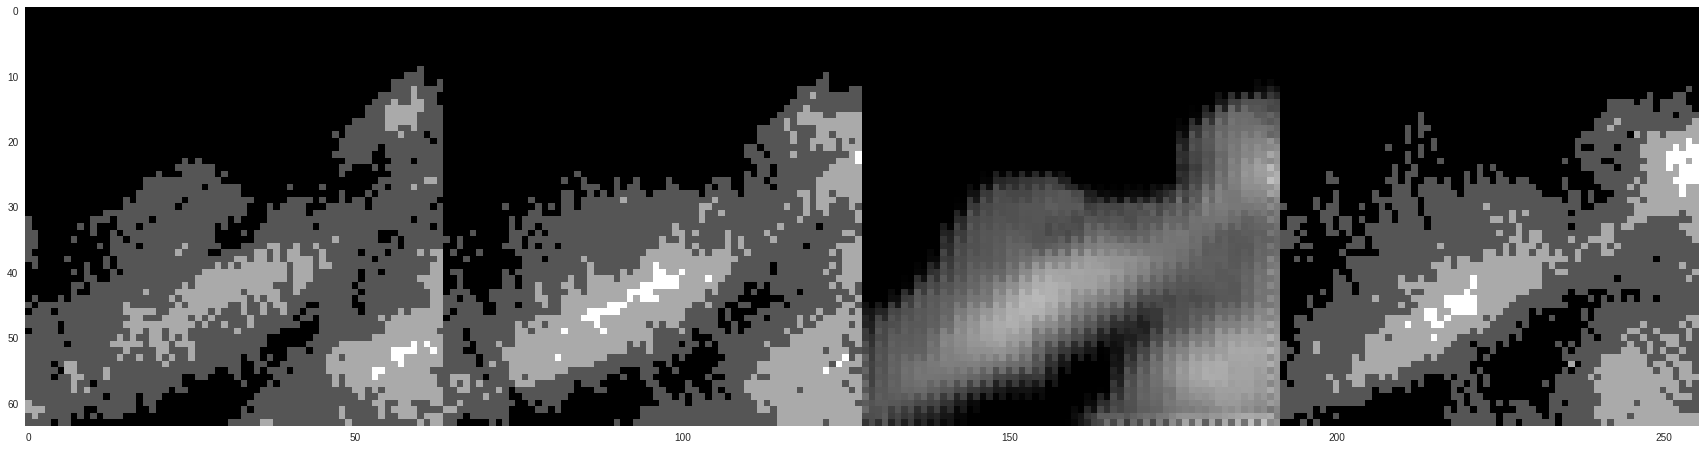

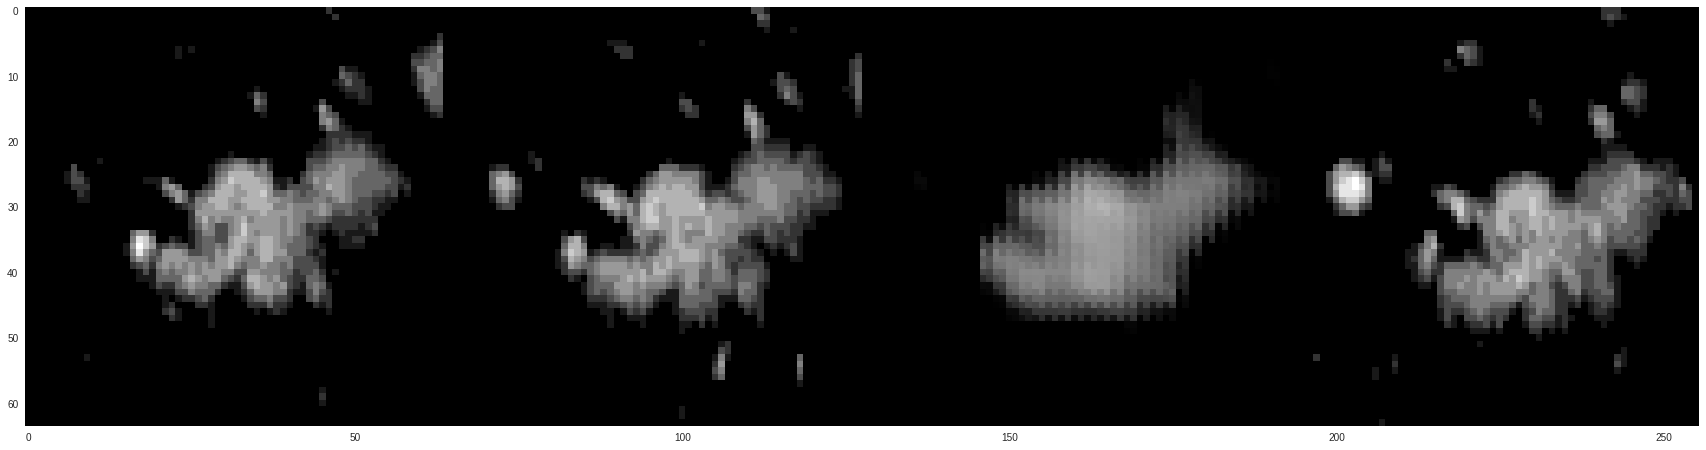

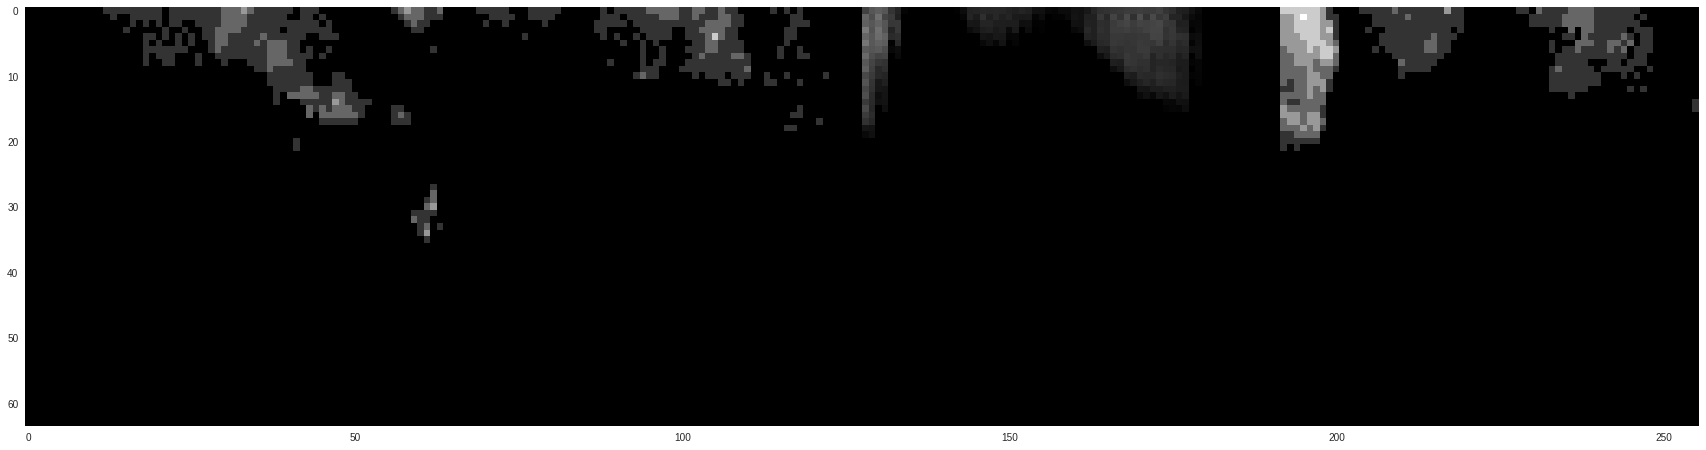

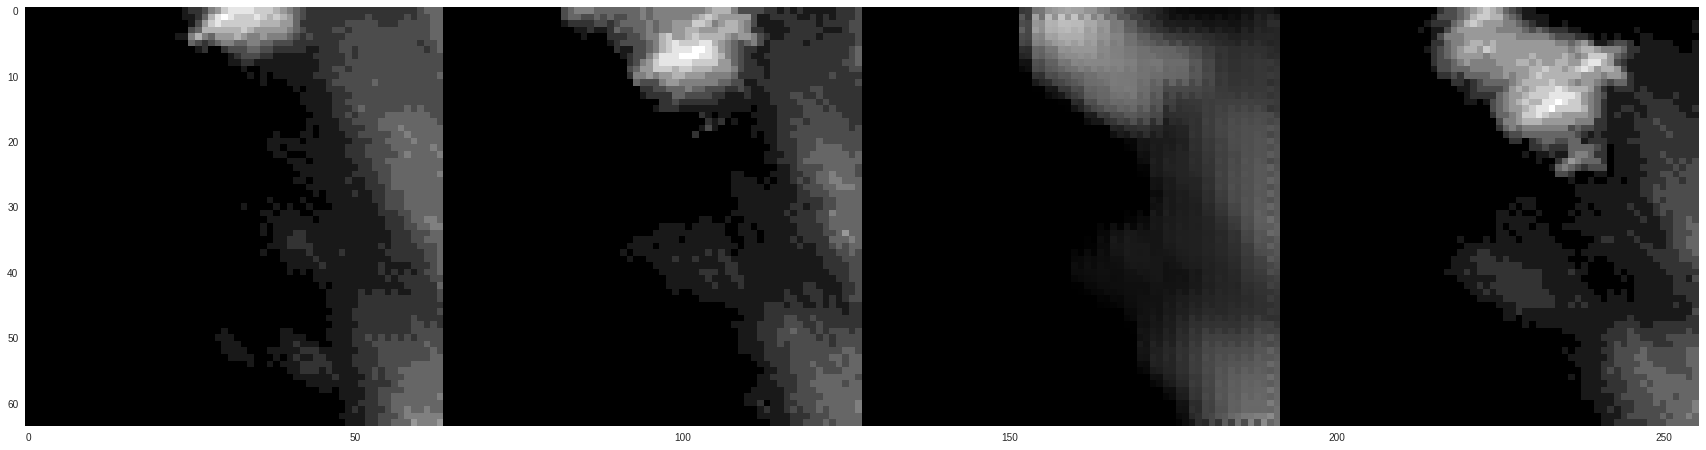

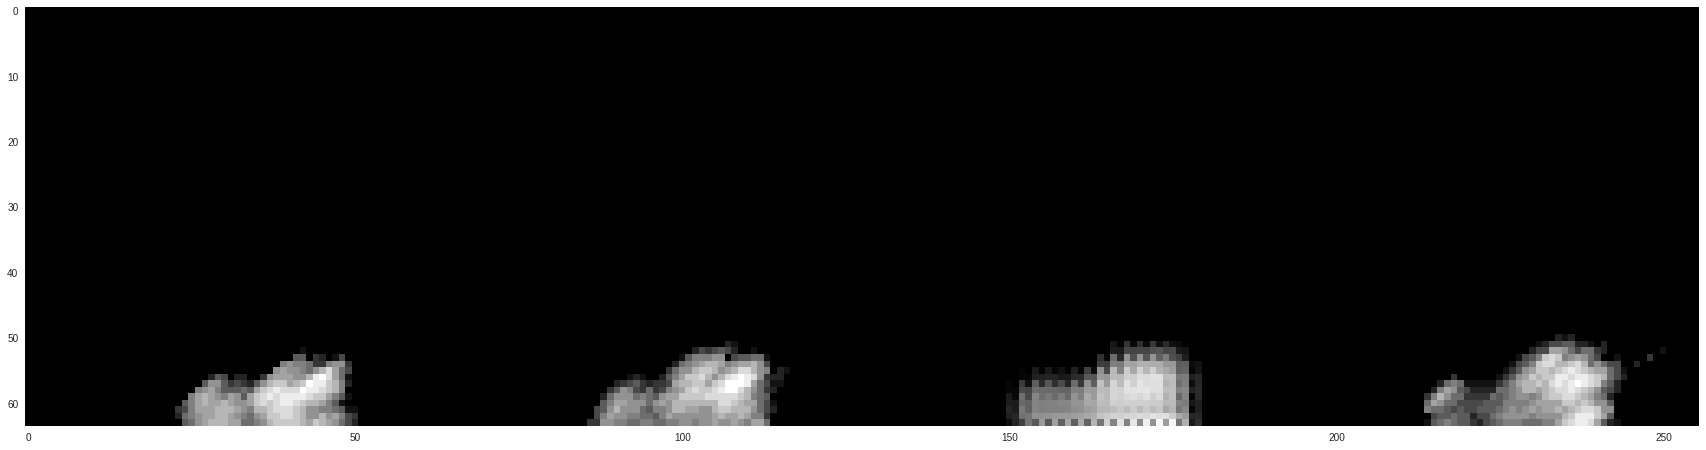

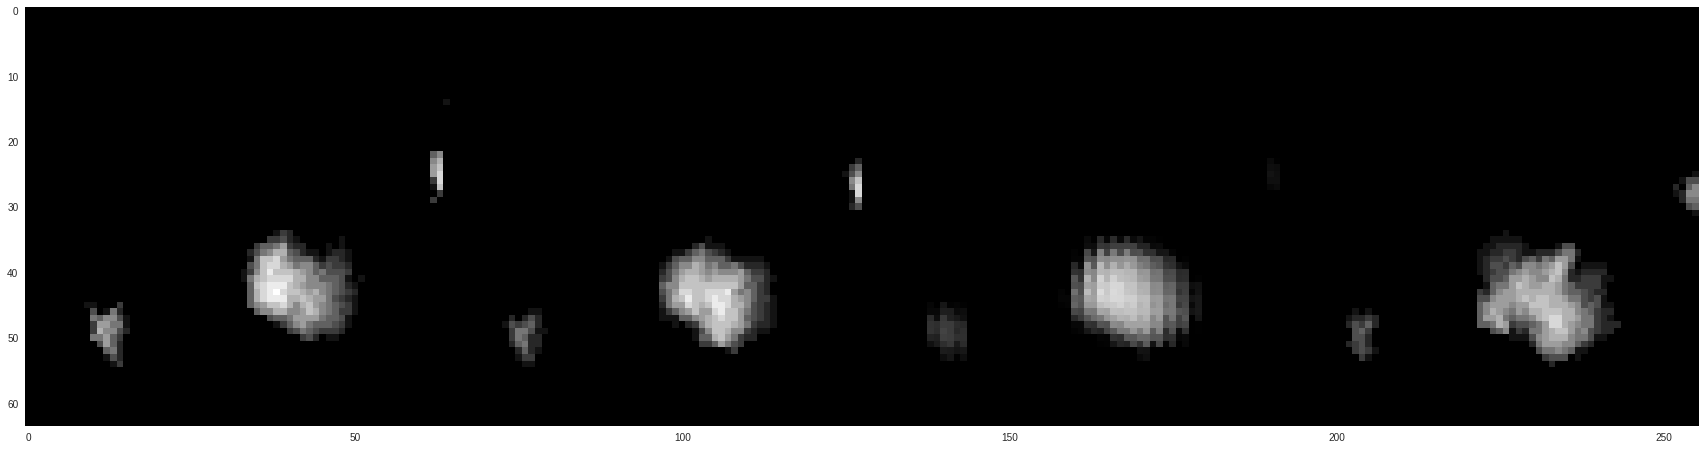

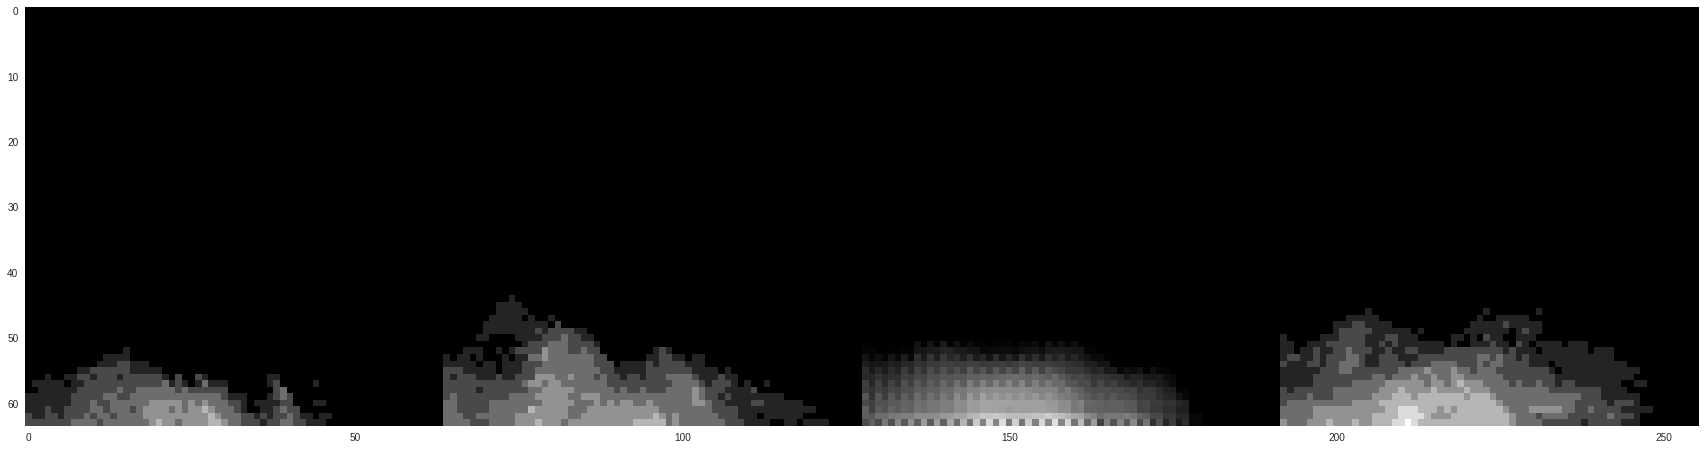

In [23]:
res = autoencoder.predict(X_test[:50])

for i in range(30):
  compareRes(i,"")

In [24]:
!zip fig.zip *.png

updating: 00.png (stored 0%)
updating: 01.png (stored 0%)
updating: 02.png (stored 0%)
updating: 03.png (stored 0%)
updating: 04.png (stored 0%)
updating: 05.png (deflated 0%)
updating: 06.png (stored 0%)
updating: 07.png (stored 0%)
updating: 08.png (stored 0%)
updating: 09.png (deflated 1%)
updating: 10.png (stored 0%)
updating: 11.png (deflated 0%)
updating: 12.png (stored 0%)
updating: 13.png (stored 0%)
updating: 14.png (deflated 1%)
updating: 15.png (stored 0%)
updating: 16.png (deflated 2%)
updating: 17.png (stored 0%)
updating: 18.png (stored 0%)
updating: 19.png (stored 0%)
updating: 20.png (stored 0%)
updating: 21.png (deflated 0%)
updating: 22.png (stored 0%)
updating: 23.png (deflated 0%)
updating: 24.png (stored 0%)
updating: 25.png (deflated 1%)
updating: 26.png (stored 0%)
updating: 27.png (deflated 5%)
updating: 28.png (stored 0%)
updating: 29.png (deflated 2%)
updating: model.png (deflated 18%)
